# Experimentation

Data exploration and understanding the task at hand is a fundamental step in the Machine Learning workflow.
In this notebook, we'll take an opportunity to explore the use case, data and models we'll be using.

We have been tasked with developing an application which can identify objects in static and live images. In this notebook we use a pre-trained machine learning model, and explore how it works on static photos. 

To begin, we import some required python packages:

In [1]:
!pip install -q opencv-python-headless
!pip install -q onnx onnxruntime

In [2]:
import sys
sys.path.append('./utils')

from os import environ

from onnxruntime import InferenceSession
from PIL import Image, ImageColor, ImageDraw, ImageFont


from utils.classes import coco_classes
from utils.images import preprocess, postprocess, draw_boxes

## Import our image

In the next cell we import the image we want to test our model on.

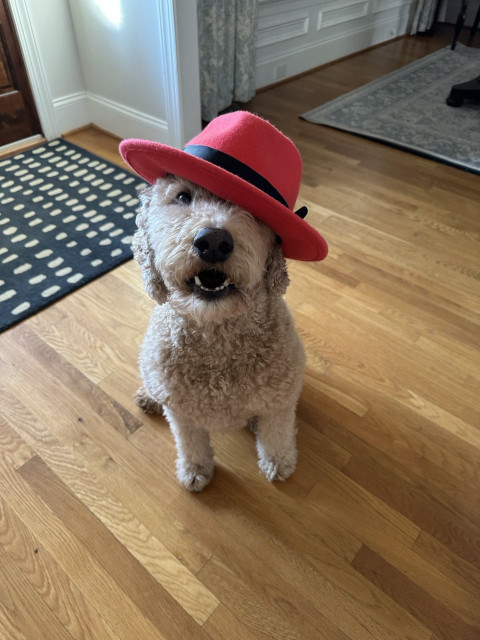

In [3]:
sample_image = 'images/redhat-dog.jpg'
sample = Image.open(sample_image)
sample

This image shows a visual scene. We need to import the image as an array so the ONNX model we will use can process the image.  If you're curious about the preprocessing code, you can take a look at the [source code](utils/images.py)

In [4]:
converted_image, scale_factor, padding = preprocess(sample_image)

## Load the Model

The model we are going to use today is the Tiny YOLO v5 model, which we've included in this repo.  Often you'll download other versions of the model.  We'll be using the [ONNX (Open Neural Network Exchange)](https://onnx.ai/) version of the model, so we can easily see how model inference equates to served models later.  ONNX models are readily served by most Serving Runtimes, including [OpenVINO model server](https://docs.openvino.ai/2023.0/ovms_what_is_openvino_model_server.html) which is included in RHODS by default.

You can convert models from most popular frameworks including PyTorch

In [5]:
MODEL_DIR="models/yolov5n"
MODEL_PATH=f"{MODEL_DIR}/model.onnx"

In [6]:
session = InferenceSession(MODEL_PATH)
raw_result = session.run(
    [], {'images': converted_image}
)[0]
raw_result

array([[[2.6900187e+00, 2.4071980e+00, 9.2801456e+00, ...,
         1.5010536e-03, 1.1938810e-03, 4.1155219e-03],
        [1.2088857e+01, 2.8214021e+00, 1.7760931e+01, ...,
         1.8310547e-03, 1.6129613e-03, 6.0420930e-03],
        [1.9455313e+01, 3.0727620e+00, 1.7841232e+01, ...,
         1.9465685e-03, 1.6533732e-03, 6.6024363e-03],
        ...,
        [5.6997418e+02, 6.2197272e+02, 1.5540779e+02, ...,
         3.0756295e-03, 9.6794963e-04, 1.3114810e-03],
        [5.9459863e+02, 6.2298267e+02, 1.2883676e+02, ...,
         2.7425289e-03, 9.6508861e-04, 1.3789237e-03],
        [6.2030200e+02, 6.2701849e+02, 1.7691681e+02, ...,
         2.4666786e-03, 8.8679790e-04, 1.3287663e-03]]], dtype=float32)

In [7]:
class_labels = coco_classes
result = postprocess(raw_result, class_labels)
result

[[[[206, 156, 397, 489]], array([0.6177563], dtype=float32), ['dog']]]

The model has returned arrays, each of which holds information about the detected objects. The information includes identifiers for the types of objects, coordinates locating the objects within the image, and detection scores, corresponding to how certain the model is about its prediction.

We can use a few functions to help us to superimpose the information in this dictionary onto the original image.

In [8]:
len(result[0])

3

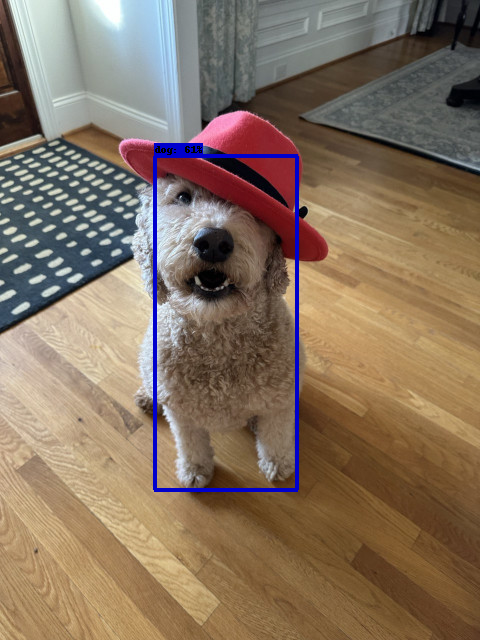

In [9]:
draw_boxes(sample_image, *result[0])

Fantastic! So you've seen how we can use a pre-trained model to identify objects in images. In the next notebooks, we will deploy this model using RHODS Model Serving, which allows us to use it as part of a larger application.